# Binaryzacja

### Zadanie domowe - binaryzacja adaptacyjna w oknach z interpolacją.

Pokazana w ramach podstawowej części ćwiczenia binaryzacja adaptacyjna działa dobrze, ale jest dość złożona obliczeniowo (choć oczywiście należy mieć świadomość, że implementację można zoptymalizować i wyeliminować pewne powtarzające się obliczenia).
Zbliżone rozwiązanie można również realizować w nieco innym wariancie - w oknach.
Ogólna idea jest następująca: wejściowy obraz dzielimy na nienachodzące (rozłączne) okna - wygodnie jest założyć, że są one kwadratowe i o rozmiarze będącym potęgą liczby 2.
W każdym z okien obliczamy próg - niech to będzie średnia i stosujemy do binaryzacji lokalnej.
Jak nietrudno się domyślić efekt nie będzie dobry, gdyż na granicach okien wystąpią artefakty.
Aby je wyeliminować należy zastosować interpolację, co zostanie szczegółowo opisane poniżej.
Warto zaznaczyć, że podobny mechanizm interpolacji stosowany jest w poznanym wcześniej algorytmie CLAHE.
Zainteresowane osoby odsyłam do artykułu na [Wikipedii](https://en.wikipedia.org/wiki/Adaptive_histogram_equalization) oraz do artykułu o metodzie CLAHE - Zuiderveld, Karel. “Contrast Limited Adaptive Histograph Equalization.” Graphic Gems IV. San Diego: Academic Press Professional, 1994. 474–485.



Na początek zaimplementujemy wariant metody bez interpolacji:
1. Wczytaj obraz _rice.png_.
2. W dwóch pętlach `for`, dla okien o ustalonym wymiarze $W$ (potęga 2), oblicz średnią:
- pętle powinny mieć krok $W$,
- wynik (tj. średnie) należy zapisać w pomocniczej tablicy,
- przydatny operator to `//` - dzielenie całkowitoliczbowe (*floor division*).

3. W kolejnych dwóch pętlach `for` (tym razem o kroku 1) przeprowadź binaryzację z wyznaczonymi progami.
   Tu oczywiście należy się sprytnie odwołać do wyników z tablicy pomocniczej.
   Wyświetl wyniki - czy jest on poprawny?
   Podpowiedź - błędy lepiej widać dla mniejszego rozmiaru okna (np. 16 x 16).

In [1]:
import cv2
import os
import requests
from matplotlib import pyplot as plt
import numpy as np

url = 'https://raw.githubusercontent.com/vision-agh/poc_sw/master/04_Thresholding/'

fileName = "rice.png"
if not os.path.exists(fileName):
    r = requests.get(url + fileName, allow_redirects=True)
    open(fileName, 'wb').write(r.content)

In [2]:
def show_image_and_binarization(image, image_binarized):
  fig, axs = plt.subplots(1, 2)
  fig.set_size_inches(12, 6)
  axs[0].axis("off")
  axs[0].imshow(image, "gray", vmin=0, vmax=255)
  axs[1].axis("off")
  axs[1].imshow(image_binarized, "gray", vmin=0, vmax=1)

  plt.show()

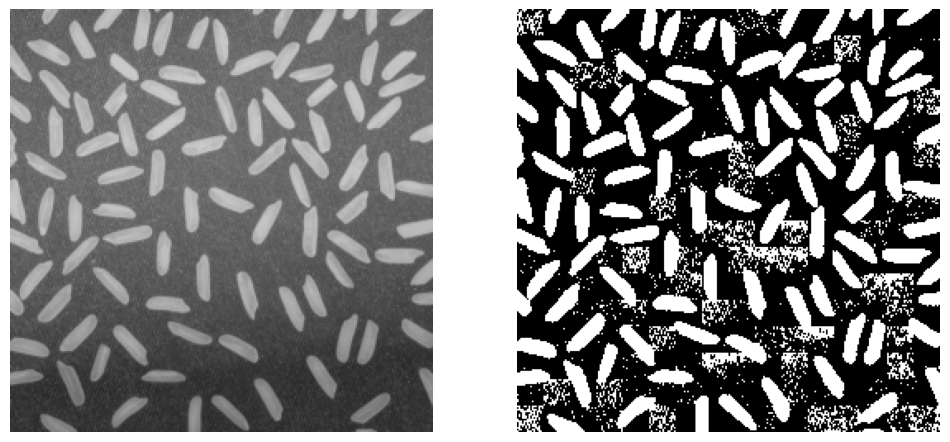

In [3]:
from math import ceil

def binarize_local_adaptive(image, local_context_size=16):
  H, W = image.shape

  means = np.empty((ceil(W / local_context_size), ceil(H / local_context_size)), dtype=np.float32)
  for j in range(0, H, local_context_size):
    for i in range(0, W, local_context_size):
      local_context = image[i:i + local_context_size, j:j + local_context_size]
      means[i // local_context_size][j // local_context_size] = local_context.mean()

  image_binarized = np.empty((W, H), dtype=np.uint8)
  for i in range(H):
    for j in range(W):
      mean = means[i // local_context_size][j // local_context_size]
      image_binarized[i][j] = image[i][j] > mean

  return image_binarized

image           = cv2.imread("rice.png", cv2.IMREAD_GRAYSCALE)
image_binarized = binarize_local_adaptive(image)
show_image_and_binarization(image, image_binarized)

4. Rozwiązaniem problemu artefaktów na obrazie jest zastosowanie interpolacji.
   Próg binaryzacji dla danego piksela wyliczany jest na podstawie progów z sąsiednich okien.
   ![Ilustracja koncepcji interpolacji](https://raw.githubusercontent.com/vision-agh/poc_sw/master/04_Thresholding/clahe_tile_interpolation.png)

   Koncepcja została przedstawiona na powyższym rysunku.
   Możliwe są 3 przypadki:
   - piksel leży w rogach obrazu (kolor czerwony) - wtedy za próg przyjmuje się wartość średniej obliczonej dla danego okna,
   - piksel leży na krawędzi obrazu (kolor zielony) - wtedy za próg przyjmuje się wartość obliczoną na podstawie średnich z dwóch sąsiednich okien,
   - piksel leży w środku (kolor fioletowy) - wtedy próg jest obliczany na podstawie 4 sąsiednich okien.

   Uwaga. Proszę zwrócić uwagę, że sprawa jest dość złożona.
   Obraz dzielimy na okna (dla nich liczymy średnią) i następnie każde z okien "wirtualnie" na cztery sub-okna (linie przerywane).
   To ułatwia znalezienie środków okien (czarne kwadraty), które są wykorzystywane w interpolacji.

5. Implementujemy interpolację.
   Potrzebujemy do tego znać progi (jeden, dwa lub cztery), ale dla przejrzystości obliczeń lepiej zawsze przyjąć cztery oraz odległości od rozważnego piksela do środka sąsiednich okien (też w ogólnym przypadku 4):
   - całość sprowadza się do określania pozycji piksela,
   - na początek rozważmy przypadek czterech narożników (kolor czerwony na rysunku) - trzeba napisać `if`, który je wyznaczy,
   - warto sprawdzić, czy nie popełniliśmy błędu i np. tymczasowo do obrazu wynikowego w tym miejscu przypisać wartość 255. Efekt powinien być taki, że widoczne będą tylko narożniki.
   - drugi przypadek do brzegi (kolor zielony) - postępujemy podobnie jak przy narożnikach, przy czym osobno wydzielamy brzegi pionowe i poziome. Tu też warto sobie obrazek "pokolorować".
   - na koniec wyznaczamy piksele w środku.
   - analizując poprawność proszę zwrócić uwagę na to, żeby nie było przerw pomiędzy obszarami.
   - mając podział możemy dla każdego z obszarów wyliczyć cztery progi ($t11, t12, t21, t22$):
        - dla narożników wartość ta będzie identyczna i wynosi po prostu `t11 =t[jT][iT]`, gdzie `iT=i//W` oraz `jT=j//W`.
          Uwaga. Proszę używać indeksów tymczasowych $jT,iT$, gdyż będą potrzebne w dalszych obliczeniach.
        - dla brzegów pionowych występują dwie wartości: okno bieżące i sąsiednie.
          Wyznaczenie współrzędnej poziomej jest proste (jak dla narożników).
          Nad współrzędną pionową trzeba się chwilę zastanowić - aby nie rozważać wielu przypadków można od bieżącej współrzędnej odjąć połowę rozmiaru okna i dopiero później wykonać dzielenie przez rozmiar okna.
          W ten sposób otrzymujemy indeks okna o mniejszej współrzędnej.
          Indeks drugiego uzyskamy dodając 1.
          Proszę się zastanowić dlaczego to działa - najlepiej to sobie rozrysować.
        - dla brzegów poziomych należy postąpić analogicznie,
        - obliczenia dla obszaru wewnątrz powinny być już oczywiste.
   - kolejny krok to wyliczenie odległości pomiędzy rozważanym pikselem, a czterema środkami.
     Przykładowo dla osi X wygląda to następująco: `dX1 = i - W/2 - iT*W` oraz `dX2 = (iT+1)*W - i-W/2`.
     Dla osi Y analogicznie.
     Ponownie proszę się zastanowić dlaczego to jest poprawne - najlepiej to sobie narysować.
   - ostatni krok to interpolacja dwuliniowa.
     Wykonamy ją w trzech krokach:
     - interpolacja w osi X dla dwóch górnych okien - sprowadza się ona do średniej ważonej pomiędzy wartościami $t11$ i $t12$, przy czym wagi to odpowiednio $dX2/W$ i $dX1/W$.
       Ponownie na podstawie rysunku proszę to przemyśleć.
     - interpolacja w osi X dla dolnych okien jest analogiczna,
     - interpolacja w osi Y również jest analogiczna, z tym, że wejściem są dwa wyniki interpolacji w poziomie.

6. "Kropka nad i" to oczywiście binaryzacja z wyznaczonym poprzez interpolację progiem - proszę dobrać rozmiar okna.
7. Na koniec proszę porównać na wspólnym rysunku poznane metody binaryzacji:
- Otsu,
- lokalna na podstawie średniej,
- lokalna Sauvoli,
- lokalna w oknach bez interpolacji,
- lokalna w oknach z interpolacją.

Proszę pod porównaniem, w osobnej sekcji *markdown*, krótko skomentować uzyskane wyniki.

In [4]:
def binarize_local_adaptive_inter(image, W=16):
  def interpolate(x1, x2, w1, w2):
    return (w1 * x1 + w2 * x2) / W

  Y, X            = image.shape
  w               = W // 2
  image_binarized = np.empty((Y, X), dtype=np.uint8)

  means = np.empty((Y // W, X // W))
  for i in range(0, Y, W):
    for j in range(0, X, W):
      means[i // W][j // W] = image[i:i + W, j:j + W].mean()

  for i in range(Y):
    for j in range(X):
      big_window_i   = i // W
      big_window_j   = j // W
      small_window_i = i // w
      small_window_j = j // w

      iT = (i - w) // W
      jT = (j - w) // W

      # Corners.
      if small_window_i in [0, X // w - 1] and small_window_j in [0, Y // w - 1]:
        t11 = t12 = t21 = t22 = means[big_window_i, big_window_j]

      # Horizontal edges.
      elif small_window_i in [0, X // w - 1]:
        t11 = t21 = means[big_window_i, jT]
        t12 = t22 = means[big_window_i, jT + 1]

      # Vertical edges.
      elif small_window_j in [0, Y // w - 1]:
        t11 = t12 = means[iT, big_window_j]
        t21 = t22 = means[iT + 1, big_window_j]

      # Interior.
      else:
        t11 = means[iT, jT]
        t12 = means[iT, jT + 1]
        t21 = means[iT + 1, jT]
        t22 = means[iT + 1, jT + 1]

      dx1 = j - w - jT * W
      dx2 = W - dx1
      dy1 = i - w - iT * W
      dy2 = W - dy1

      xt1 = interpolate(t11, t12, dx2, dx1)
      xt2 = interpolate(t21, t22, dx2, dx1)
      t   = interpolate(xt1, xt2, dy2, dy1)

      image_binarized[i, j] = image[i, j] > t

  return image_binarized

In [5]:
def show_binarization_output(image, image_binarized, title):
  print(title)

  fig, axs = plt.subplots(1, 2)
  fig.set_size_inches(12, 5)
  axs[0].axis("off")
  axs[0].imshow(image, "gray", vmin=0, vmax=255)
  axs[1].axis("off")
  axs[1].imshow(image_binarized, "gray", vmin=0, vmax=1)

  plt.show()


def calculate_threshold_otsu(image):
  histogram            = cv2.calcHist([image], [0], None, [256], [0, 256]).squeeze()
  total_pixels         = image.shape[0] * image.shape[1]
  histogram_normalized = histogram / total_pixels
  mean_global          = np.dot(np.arange(256), histogram_normalized)
  sigmas_class         = np.zeros(256)
  mean_step            = 0
  P_step               = 0

  for i in range(256):
    P_step    += histogram_normalized[i]
    mean_step += i * histogram_normalized[i]

    if 0 < P_step < 1:
      sigmas_class[i] = (mean_global * P_step - mean_step)**2 / (P_step * (1 - P_step))

  return np.argmax(sigmas_class), sigmas_class


def binarize_local(image, local_context_size=16):
  H, W     = image.shape
  lcs_half = local_context_size // 2

  image_binarized = np.zeros((H, W), dtype=np.uint8)

  for i in range(lcs_half, H - lcs_half):
    for j in range(lcs_half, W - lcs_half):
      local_context         = image[i - lcs_half:i + lcs_half, j - lcs_half:j + lcs_half]
      local_mean            = local_context.mean()
      image_binarized[i][j] = image[i][j] > local_mean

  return image_binarized


def binarize_local_optimized(image, local_context_size=16, k=0.15, sign=-1):
  R        = 128
  W, H     = image.shape
  lcs_half = local_context_size // 2

  image_binarized = np.zeros((W, H), dtype=np.uint8)

  for j in range(lcs_half, H - lcs_half):
    for i in range(lcs_half, W - lcs_half):
      local_context = image[i - lcs_half:i + lcs_half, j - lcs_half:j + lcs_half]
      local_mean    = local_context.mean()
      local_std     = local_context.std()
      image_binarized[i][j] = \
        image[i][j] > local_mean * (1 - k * (local_std / R - 1))

  return image_binarized

Otsu


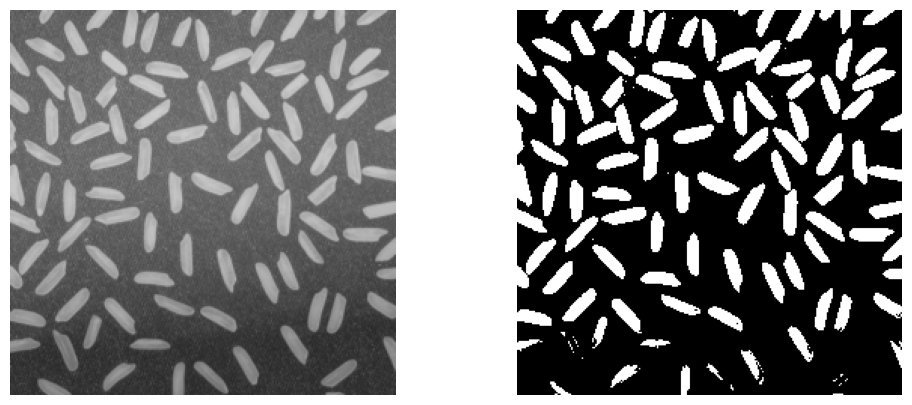

Local (mean)


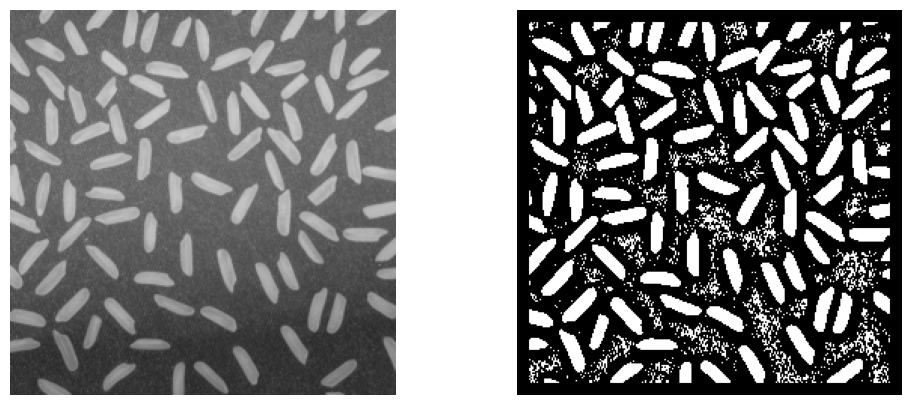

Local (optimized)


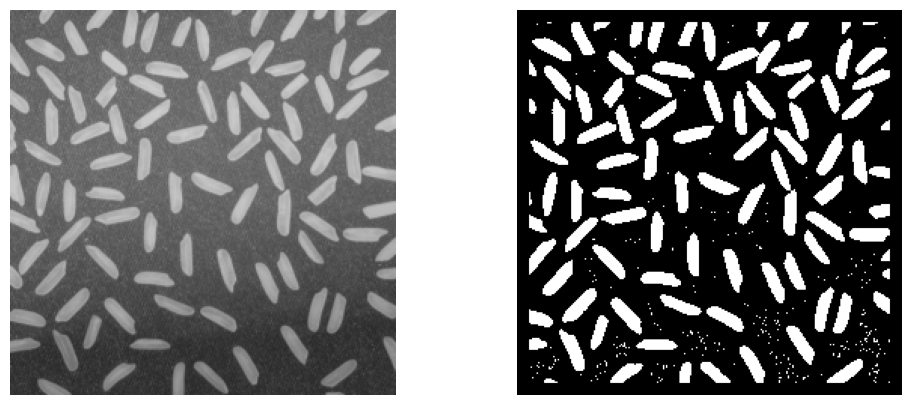

Local (adaptive without interpolation)


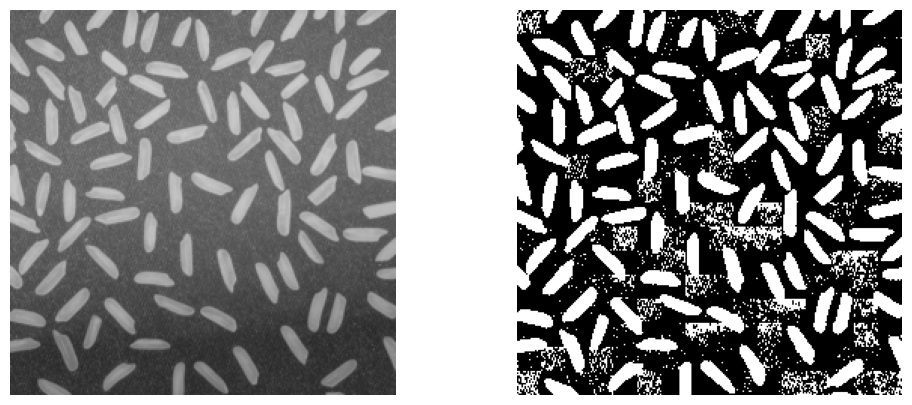

Local (adaptive with interpolation)


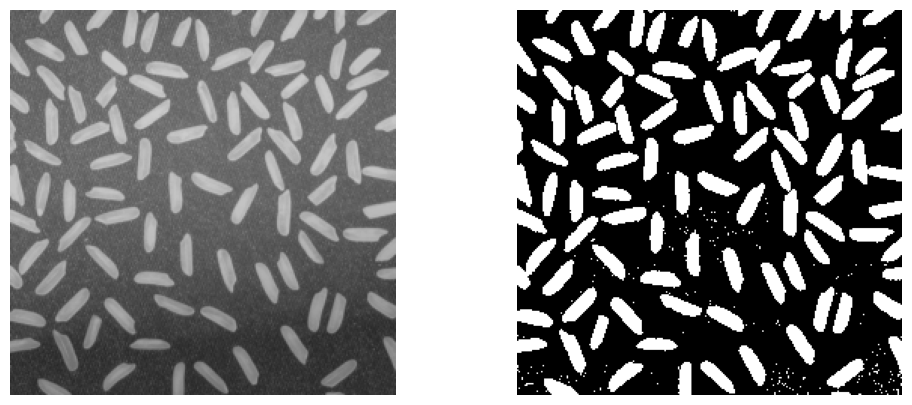

In [6]:
threshold, _ = calculate_threshold_otsu(image)
show_binarization_output(image, (image > threshold).astype(np.uint8), "Otsu")
show_binarization_output(image, binarize_local(image), "Local (mean)")
show_binarization_output(image, binarize_local_optimized(image), "Local (optimized)")
show_binarization_output(image, binarize_local_adaptive(image), "Local (adaptive without interpolation)")
show_binarization_output(image, binarize_local_adaptive_inter(image, 32), "Local (adaptive with interpolation)")

##### Komentarz
Najlepszymi metodami w powyższym przypadku są binaryzacje:
  - lokalna i adaptacyjna z wykorzystaniem interpolacji;
  - lokalna i adaptacyjna z wykorzystaniem metody Sauvoli i Pietikainena.

Drugi sposób ma swoją wadę, uzależnioną od rozmiaru lokalnego okna, nie uwzględnia brzegów obrazu w porównaniu do metody z wykorzystaniem interpolacji.


Metoda Otsu też jest dobra, niestety, przy ciemniejszym oświetleniu ucieła ziarenka ryżu (dolna część), natomiast poradziła sobie lepiej z szumem.